<a href="https://colab.research.google.com/github/SauravMaheshkar/medical/blob/main/fMRI/CLIPvoxel_to_CLIPimage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook takes CLIP-voxels (brain voxels that have already been mapped to CLIP space via contrastive learning) and then uses a diffusion model to better align these CLIP-voxels to CLIP-image space (i.e., this is how DallE-2 uses a diffusion prior to go from CLIP-text space to CLIP-image space, as the spaces are still disjointed after contrastive learning).

# Import packages & functions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import math
import random
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
from datetime import datetime
import h5py
import webdataset as wds
from info_nce import InfoNCE
import clip
import pandas as pd
from collections import OrderedDict
from IPython.display import clear_output

from utils import * 
from models import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

seed_everything(seed=0)

/home/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda


In [2]:
# setup multi-gpu Data Distributed Processing (ddp) if available
# if not using ddp, using_ddp should be False and local_rank=0
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import ddp_config
using_ddp, local_rank = ddp_config.ddp_test()
if device=='cuda':
    torch.cuda.set_device(local_rank)

NOT using distributed parallel processing!


In [3]:
# if full_training is True, use large batches and the entire training dataset 
full_training = True
print('full_training:',full_training)

full_training: True


## Which pretrained model are you using for voxel alignment to embedding space? 

In [4]:
modality = "image"
clip_variant = "ViT-L/14"
# img_augmentation = True # do image augmentation?
# soft_clip = True # use loss_nce + loss_soft? (seems to improve fwd/bwd retrieval)
clamp_embs = False # clamp embeddings to (-1.5, 1.5)
norm_embs = False # L2 norm embeddings after clamping (must be False for training the prior)

In [5]:
assert clip_variant in ("RN50", "ViT-L/14", "ViT-B/32")
if modality == "text":
    image_var = "trail"
elif modality == "image":
    image_var = "images"
else:
    raise Exception(f"Unknown modality: {modality}")
print("image_var =", image_var)

image_var = images


In [6]:
assert norm_embs == False, 'norm embs must be False for training the prior'

clip_extractor = Clipper(clip_variant, clamp_embs=clamp_embs, norm_embs=norm_embs)
# # load COCO annotations curated in the same way as the mind_reader (Lin Sprague Singh) preprint
# f = h5py.File('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_subj_indices.hdf5', 'r')
# subj01_order = f['subj01'][:]
# f.close()
# annots = np.load('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_annots_curated.npy',allow_pickle=True)
# subj01_annots = annots[subj01_order]

ViT-L/14 cuda


# Prep dataloaders and brain_to_clip model

In [7]:
batch_size = 128
#batch_size = 256
num_devices = torch.cuda.device_count()
num_workers = num_devices

train_dl, val_dl = get_dataloaders(batch_size, image_var, num_workers=num_workers)

batch_size 128
num_devices 1
num_workers 1
global_batch_size 128
num_worker_batches 195
validation: num_worker_batches 4


In [8]:
# get first batches
for train_i, (voxel0, image0) in enumerate(train_dl):
    break

for val_i, (val_voxel0, val_image0) in enumerate(val_dl):
    break

In [9]:
# from models.py
brain_net = BrainNetwork(768) 
if using_ddp:
    brain_net0 = brain_net.to(local_rank)
    brain_net = DDP(brain_net0, device_ids=[local_rank])
else:
    brain_net = brain_net.to(device)

In [10]:
sd_pipe, unet, vae, noise_scheduler = load_sd_pipeline()

Fetching 11 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 9406.19it/s]


# Train Diffusion Prior

This will map the CLIP-voxel embeddings to the CLIP-image embeddings space. Right now they are disjointed embedding spaces despite being aligned to maximize same-pair cosine similarity.

In [11]:
# Loading checkpoint
#ckpt_path = f'checkpoints/{model_name}_subj01_epoch19.pth'
#ckpt_path = f'checkpoints/clip_image_vitL_augTrue_softTrue_clampFalse_normFalse_subj01_epoch19.pth'
ckpt_path = f'checkpoints/clip_image_vitL_2stage_mixco_lotemp_125ep_subj01_best.pth'
#ckpt_path = 'checkpoints/clip_image_vitL_augTrue_softTrue_clampFalse_normTrue_100ep_sumLoss_subj01_epoch44.pth'

print("ckpt_path",ckpt_path)

checkpoint = torch.load(ckpt_path, map_location=device)    
if 'model_state_dict' in checkpoint:
    brain_net.load_state_dict(checkpoint['model_state_dict'])
    plot_brainnet_ckpt(ckpt_path)
else:
    brain_net.load_state_dict(checkpoint)
    print('nothing to plot')
    
brain_net.eval()
brain_net.requires_grad_(False);

ckpt_path checkpoints/clip_image_vitL_2stage_mixco_lotemp_125ep_subj01_best.pth
nothing to plot


In [12]:
def test_voxel2clip():
    """ Run the thing that Voxel_to_CLIP.ipynb runs at the end """
    
    url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
    num_worker_batches = 10
    eval_batch_size = 300
    val_data = wds.DataPipeline([wds.ResampledShards(url),
                        wds.tarfile_to_samples(),
                        wds.decode("torch"),
                        wds.rename(images="jpg;png", voxels="nsdgeneral.npy", 
                                    embs="sgxl_emb.npy", trial="trial.npy"),
                        wds.to_tuple("voxels", "images", "trial"),
                        wds.batched(eval_batch_size, partial=True),
                    ]).with_epoch(num_worker_batches)
    val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                           batch_size=None, shuffle=False, persistent_workers=True)

    for val_i, (voxel, img, trial) in enumerate(val_dl):
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                voxel = voxel.to(device)

                if "image" in ckpt_path: # using images
                    emb0 = clip_extractor.embed_image(img)
                else:
                    emb0 = clip_extractor.embed_curated_annotations(subj01_annots[trial])

                emb_0 = nn.functional.normalize(brain_net(voxel),dim=-1)  # brain embeddings

                labels = torch.arange(len(emb0)).to(device)
                similarities0_bwd = batchwise_cosine_similarity(emb0,emb_0)  # clip, brain
                similarities0_fwd = batchwise_cosine_similarity(emb_0,emb0)  # brain, clip

                if val_i==0:
                    cnt=1
                    percent_correct_fwd = topk(similarities0_fwd, labels,k=1)
                    percent_correct_bwd = topk(similarities0_bwd, labels,k=1)
                else:
                    cnt+=1
                    percent_correct_fwd += topk(similarities0_fwd, labels,k=1)
                    percent_correct_bwd += topk(similarities0_bwd, labels,k=1)
    percent_correct_fwd /= cnt
    percent_correct_bwd /= cnt
    print("fwd percent_correct", percent_correct_fwd)
    print("bwd percent_correct", percent_correct_bwd)

    # plot results from one batch
    similarities0_fwd = np.array(similarities0_fwd.detach().cpu())
    fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
    for trial in range(4):
        ax[trial, 0].imshow(torch_to_Image(img[trial]))
        ax[trial, 0].set_title("original\nimage")
        ax[trial, 0].axis("off")
        for attempt in range(5):
            which = np.flip(np.argsort(similarities0_fwd[trial]))[attempt]
            ax[trial, attempt+1].imshow(torch_to_Image(img[which]))
            ax[trial, attempt+1].set_title(f"Top {attempt+1}")
            ax[trial, attempt+1].axis("off")
    fig.tight_layout()
    plt.show()

In [13]:
#test_voxel2clip()

In [14]:
def get_ckpt_path(tag):
    return ckpt_path.replace('.pth', '') + f'_diffusionprior_{model_tag}_{tag}.pth'

def save_ckpt(tag):
    ckpt_path = get_ckpt_path(tag)
    print(f'saving {ckpt_path}')
    
    if (using_ddp==False) or (using_ddp==True and local_rank==0):
        state_dict = brain_net.state_dict()
        if using_ddp: # if using DDP, convert DDP state_dict to non-DDP before saving
            for key in list(state_dict.keys()):
                if 'module.' in key:
                    state_dict[key.replace('module.', '')] = state_dict[key]
                    del state_dict[key]   
        torch.save({
            'epoch': epoch,
            'model_state_dict': diffusion_prior.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': losses,
            'val_losses': val_losses,
            'lrs': lrs,
            }, ckpt_path)

In [15]:
from dalle2_pytorch import DiffusionPriorNetwork, DiffusionPrior

# setup prior network, which contains an autoregressive transformer
prior_network = DiffusionPriorNetwork(
    dim = 768,
    depth = 6,
    dim_head = 64,
    heads = 8
).to(device)

diffusion_prior = DiffusionPrior(
    net = prior_network,
    #clip = clip_model,
    image_embed_dim = 768,
    condition_on_text_encodings = False,
    timesteps = 100,
    cond_drop_prob = 0.2
).to(device)

In [16]:
count_params(diffusion_prior)

param counts:
53,302,544 total
53,302,528 trainable


In [17]:
# diffusion_prior
diffusion_prior.noise_scheduler.loss_fn

<function torch.nn.functional.mse_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>

In [18]:
for x in ['num_time_embeds', 'num_image_embeds', 'num_text_embeds', 'max_text_len', 'self_cond']:
    print(x, getattr(prior_network, x))

num_time_embeds 1
num_image_embeds 1
num_text_embeds 1
max_text_len 256
self_cond False


In [19]:
for x in ['text_cond_drop_prob', 'image_cond_drop_prob', 'can_classifier_guidance', 
          'condition_on_text_encodings', 'predict_x_start', 'predict_v', 'image_embed_scale',
          'sampling_clamp_l2norm', 'sampling_final_clamp_l2norm', 'training_clamp_l2norm', 'init_image_embed_l2norm',
         ]:
    print(x, getattr(diffusion_prior, x))

text_cond_drop_prob 0.2
image_cond_drop_prob 0.2
can_classifier_guidance True
condition_on_text_encodings False
predict_x_start True
predict_v False
image_embed_scale 27.712812921102035
sampling_clamp_l2norm False
sampling_final_clamp_l2norm False
training_clamp_l2norm False
init_image_embed_l2norm False


In [20]:
epoch = 0
num_epochs = 60

lr = 3e-4
#lr = 1e-3
#lr = 1e-2
optimizer = torch.optim.AdamW(diffusion_prior.parameters(), lr=lr)
lr_scheduler = None

# initial_learning_rate = 1e-3 #3e-5
# optimizer = torch.optim.AdamW(diffusion_prior.parameters(), lr=initial_learning_rate)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-4, 
#                                             total_steps=num_epochs*((24983//batch_size)//num_devices), 
#                                             final_div_factor=1000,
#                                             last_epoch=-1, pct_start=2/num_epochs)

losses, val_losses, lrs = [], [], []
best_val_loss = 1e9

# resume from checkpoint:
# prior_checkpoint = torch.load(f'{ckpt_path[:-12]}_epoch{epoch}_diffusionprior.pth', 
#                               map_location=device)
# epoch = prior_checkpoint['epoch']+1
# diffusion_prior.load_state_dict(prior_checkpoint['model_state_dict'])
# losses = prior_checkpoint['train_losses']
# optimizer.load_state_dict(prior_checkpoint['optimizer_state_dict'])
# optimizer.param_groups[0]['lr'] = lr

model_tag = f'lr={lr}'
model_tag

'lr=0.0003'

In [21]:
get_ckpt_path('best')

'checkpoints/clip_image_vitL_2stage_mixco_lotemp_125ep_subj01_best_diffusionprior_lr=0.0003_best.pth'

In [26]:
# bs = 2

In [ ]:
# feed text and images into diffusion prior network
progress_bar = tqdm(range(epoch,num_epochs),ncols=250)
for epoch in progress_bar:
    diffusion_prior.train()
    for train_i, (voxel, image) in enumerate(train_dl):
    #for train_i, (voxel, image) in enumerate([(voxel0[:bs], image0[:bs])]):
        optimizer.zero_grad()
        image = image.to(device)

        clip_embed = brain_net(voxel.to(device).float())
        #clip_embed = nn.functional.normalize(clip_embed,dim=-1)

        # clip_embed = clip_extractor.embed_curated_annotations(subj01_annots[voxel])

        image_clip = clip_extractor.embed_image(image).float()

        loss = diffusion_prior(text_embed=clip_embed, image_embed=image_clip)
        
        loss.backward()
        optimizer.step()
        if lr_scheduler is not None:
            lr_scheduler.step() 

        losses.append(loss.item())
        lrs.append(optimizer.param_groups[0]['lr'])
        
    diffusion_prior.eval()
    for val_i, (val_voxel, val_image) in enumerate(val_dl):
    #for val_i, (val_voxel, val_image) in enumerate([(val_voxel0[:bs], val_image0[:bs])]):
        
        with torch.no_grad(): 
            val_image = val_image.to(device)

            clip_embed = brain_net(val_voxel.to(device).float())
            #clip_embed = nn.functional.normalize(clip_embed,dim=-1)

            # clip_embed = clip_extractor.embed_curated_annotations(subj01_annots[voxel])

            image_clip = clip_extractor.embed_image(val_image).float()

            val_loss = diffusion_prior(text_embed=clip_embed, image_embed=image_clip)

            val_losses.append(val_loss.item())
            
    clear_output(wait=True)
    
    val_loss = np.mean(val_losses[-(val_i+1):])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_ckpt('best')
    
    # Save model checkpoint every 5 epochs if full_training==True
    if (epoch+1)%5==0 and full_training:
        # diff_ckpt_path = ckpt_path.replace('.pth', '|') + f'epoch{epoch:03d}_diffusionprior_lrCycle.pth'
        save_ckpt(f'epoch{epoch:03d}')
        
        if using_ddp:
            dist.barrier() # this tells the other gpus wait for the first gpu to finish saving the model
    
    logs = OrderedDict(
        loss=np.mean(losses[-(train_i+1):]),
        val_loss=np.mean(val_losses[-(val_i+1):]),
        lr=lrs[-1],
    )
    progress_bar.set_postfix(**logs)
    
    if True: #epoch % 5 == 0:
        # clear_output(wait=True)
        
        plot_prior(losses, val_losses, lrs)
        
        print('-'*100)
        print('train')

        sample_images(
            clip_extractor, brain_net, unet, vae, noise_scheduler, diffusion_prior,
            voxel0[:2], image0[:2],
        )
        
        print('-'*100)
        print('val')
        
        sample_images(
            clip_extractor, brain_net, unet, vae, noise_scheduler, diffusion_prior,
            val_voxel0[:2], val_image0[:2],
        )

prior_ckpt_path checkpoints/clip_image_vitL_2stage_mixco_lotemp_125ep_subj01_best_diffusionprior_lr=0.0003_best.pth


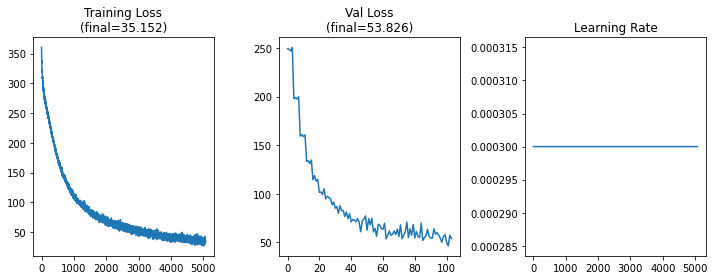

epoch 25
n_steps 5070


In [21]:
# load pretrained checkpoint
# prior_ckpt_path = f'{ckpt_path[:-12]}_epoch24_diffusionprior.pth'
#prior_ckpt_path = '/home/jimgoo/data/neuro/clip_image_vitL_2stage_mixco_lotemp_125ep_subj01_best|epoch004_diffusionprior-jimgoo.pth'
#prior_ckpt_path = 'checkpoints/clip_image_vitL_augTrue_softTrue_clampFalse_normFalse_subj01_epoch19|epoch039_diffusionprior-jimgoo.pth'
#prior_ckpt_path = '/home/jimgoo/data/neuro/clip_image_vitL_2stage_mixco_lotemp_125ep_subj01_best|epoch034_diffusionprior_lrCycle.pth'
prior_ckpt_path = get_ckpt_path('best')
print('prior_ckpt_path', prior_ckpt_path)

plot_prior_ckpt(prior_ckpt_path)

prior_checkpoint = torch.load(prior_ckpt_path, map_location=device)
print('epoch', prior_checkpoint['epoch'])
print('n_steps', len(prior_checkpoint['train_losses']))

diffusion_prior.load_state_dict(prior_checkpoint['model_state_dict'])
diffusion_prior=diffusion_prior.to(device)

diffusion_prior.eval()
diffusion_prior.requires_grad_(False)

prior_network.eval()
prior_network.requires_grad_(False)

brain_net.eval()
brain_net.requires_grad_(False);

In [22]:
# for i, (voxel, image) in enumerate(val_dl):
# #for i, (voxel, image) in enumerate(train_dl):
#     image_test = image.to(device)
#     clip_embed = brain_net(voxel.to(device).float())
#     break

In [23]:
# #22
# for idx in range(4):
#     plt.imshow(torch_to_Image(image_test[idx]))
#     plt.axis('off')
#     plt.show()

#     image_clip = clip_extractor.embed_image(image_test[idx][None])
#     orig_vox_clip = clip_embed[idx][None]
    
#     print("norm of orig clip", image_clip.norm().item())
#     print("norm before prior", clip_embed[idx][None].norm().item())

#     with torch.no_grad():
#         align_vox_clip = diffusion_prior.p_sample_loop(clip_embed[idx][None].shape, 
#                                                        text_cond = dict(text_embed = clip_embed[idx][None].long()), 
#                                                        cond_scale = 1., timesteps = 100)
#         print("norm after prior", align_vox_clip.norm().item())
    
#     print("Cosine sim for CLIP-voxel x CLIP-image", nn.functional.cosine_similarity(orig_vox_clip.float(),image_clip,dim=1))
#     print("Cosine sim for CLIP-voxel-aligned x CLIP-image",nn.functional.cosine_similarity(align_vox_clip.float(),image_clip,dim=1))

#     plt.plot(image_clip.detach().cpu().numpy().flatten(),c='k')
#     plt.plot(orig_vox_clip.detach().cpu().numpy().flatten(),ls='--')
#     plt.show()

#     plt.plot(image_clip.detach().cpu().numpy().flatten(),c='k')
#     plt.plot(align_vox_clip.detach().cpu().numpy().flatten(),c='orange',ls='--')
#     plt.show()

# Test out feeding these aligned CLIP-voxel embeddings through Stable Diffusion (Image Variation) model

seed 100
setting seed 100
sampling with timesteps 100 is_ddim False


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.10it/s]


Cosine sim: 0.870
norms | orig: 18.312, pre_prior: 275.215, post_prior: 19.352


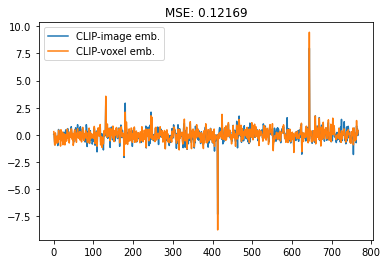

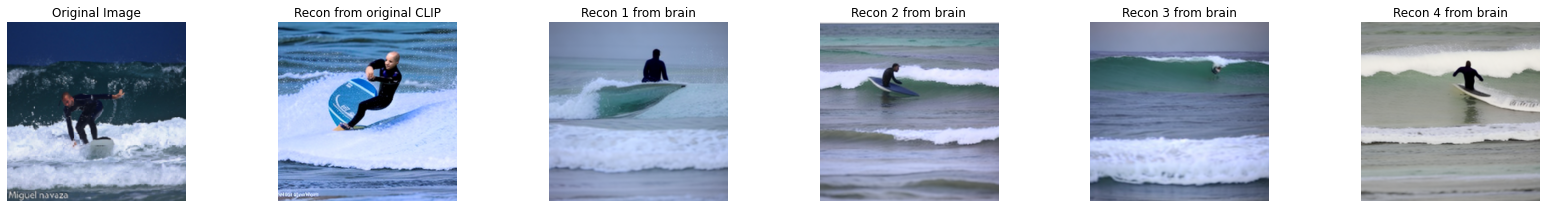

setting seed 100
sampling with timesteps 100 is_ddim False


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.33it/s]


Cosine sim: 0.814
norms | orig: 20.016, pre_prior: 265.599, post_prior: 19.368


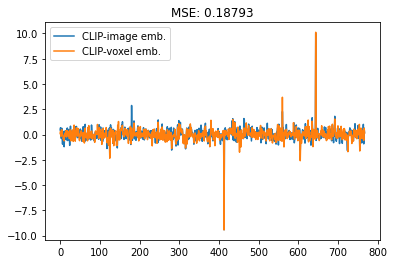

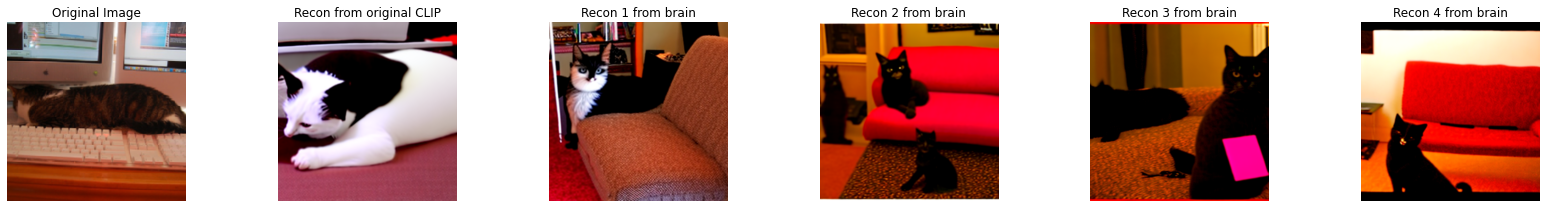

setting seed 100
sampling with timesteps 100 is_ddim False


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.03it/s]


Cosine sim: 0.768
norms | orig: 19.406, pre_prior: 265.705, post_prior: 18.979


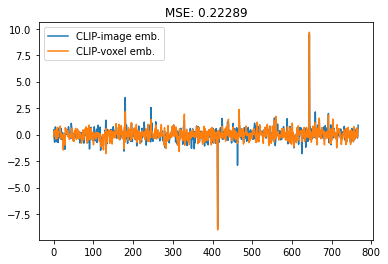

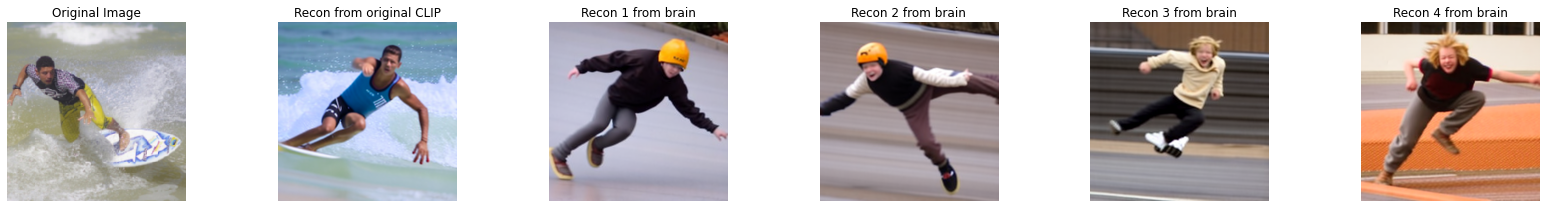

setting seed 100
sampling with timesteps 100 is_ddim False


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.42it/s]


Cosine sim: 0.744
norms | orig: 19.062, pre_prior: 262.951, post_prior: 18.701


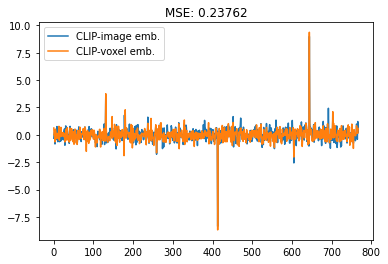

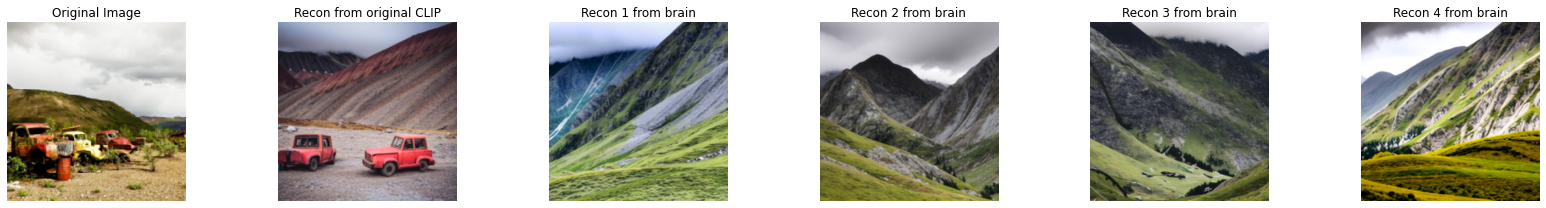

setting seed 100
sampling with timesteps 100 is_ddim False


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.16it/s]


Cosine sim: 0.693
norms | orig: 19.469, pre_prior: 319.241, post_prior: 17.258


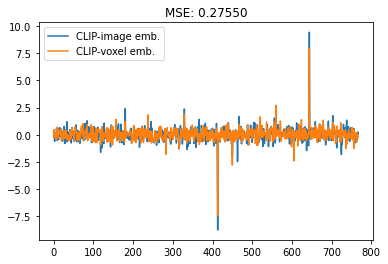

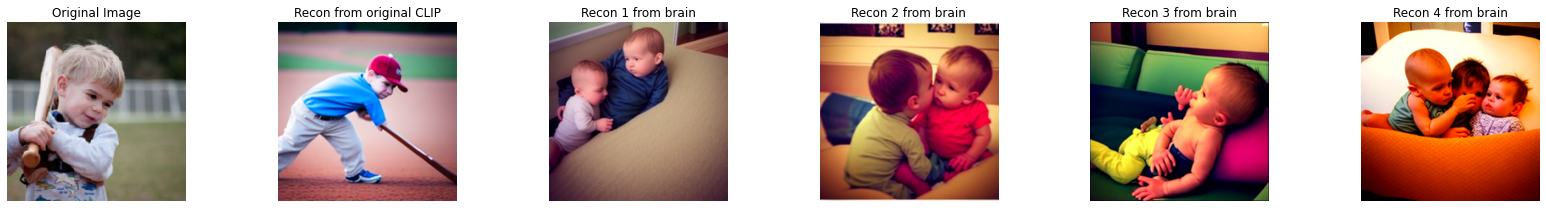

setting seed 100
sampling with timesteps 100 is_ddim False


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.30it/s]


Cosine sim: 0.764
norms | orig: 19.234, pre_prior: 241.973, post_prior: 17.456


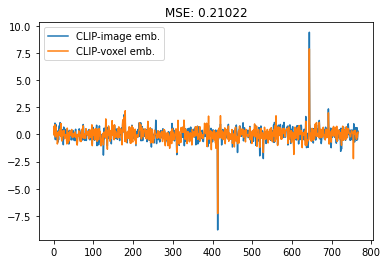

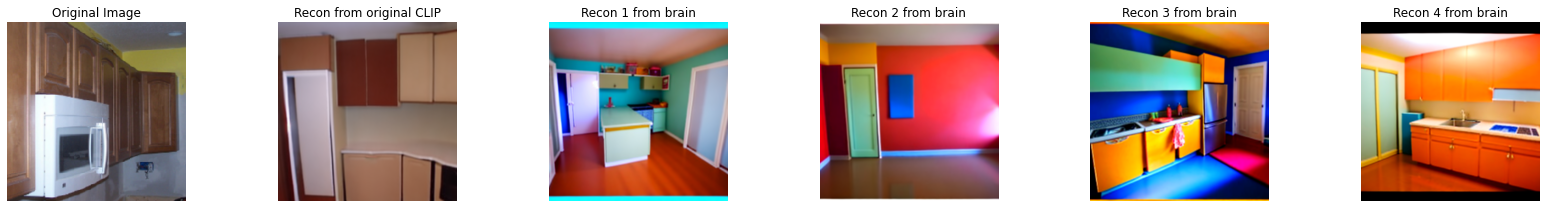

setting seed 100
sampling with timesteps 100 is_ddim False


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.44it/s]


Cosine sim: 0.607
norms | orig: 18.766, pre_prior: 246.401, post_prior: 17.049


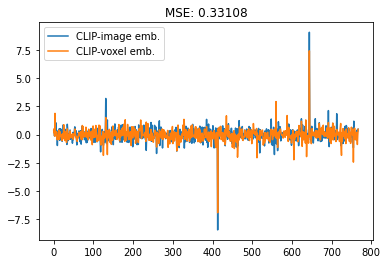

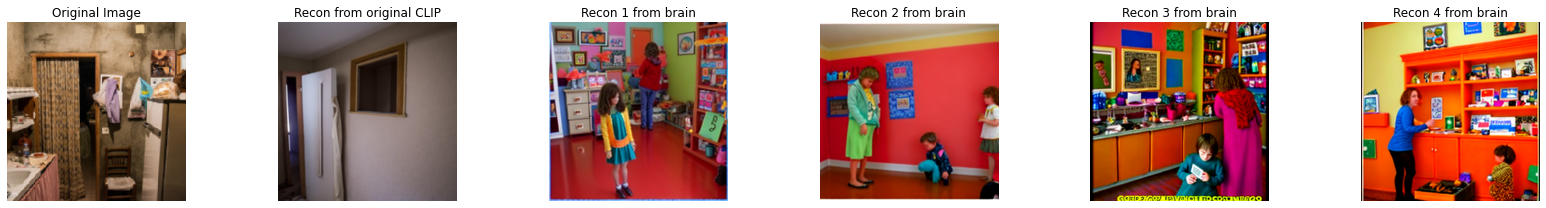

setting seed 100
sampling with timesteps 100 is_ddim False


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.13it/s]


Cosine sim: 0.710
norms | orig: 20.188, pre_prior: 300.123, post_prior: 18.417


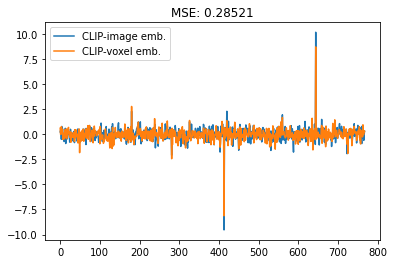

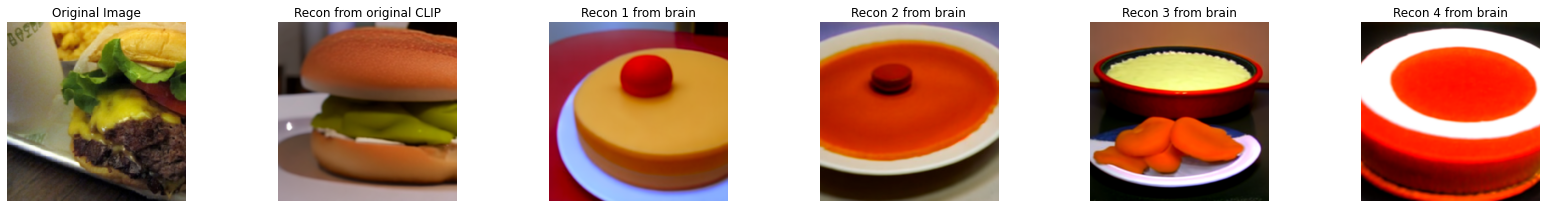

In [28]:
#seed_everything(100)

n_examples = 8

sample_images(
    clip_extractor, brain_net, unet, vae, noise_scheduler, diffusion_prior,
    val_voxel0[:n_examples], val_image0[:n_examples], 
    seed=100,
)